### Import Libraries
 - csv for loading and exporting csv files
 - pandas for data manipulation
 - numpy for array manipulation
 - matplotlib for plotting

In [1]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Filter Data to 2016

PM 2.5 data is filtered from intially data ranging from 2001 to 2016 into data containg only 2016. The columns which are unimportant are then dropped. The following columns are left in the data:

Column Header | Description
 -------------- | -------------
year | contains the year the PM 2.5 observation occured
date | The date of the PM 2.5 observation
statefpis | The state FPIS code, a integer number identifying the state of the observation
countyfpis | The County FPIS code, a integer number identifying the county of the observation
averagepm2.5 | The average PM 2.5 which occured in the area of observation.

The data was then exported to the file pm25_2016.csv for further filtering

In [ ]:

fn = '../Data/Daily_PM2.5_Concentrations_All_County__2001-2016.csv'

f = open(fn, 'r')
reader = csv.reader(f)
headers = None
newcsv=[]
for row in reader:
    headers=row
    break
print(headers)
for row in reader:
    if row[0] == '2016':
        #print(row)
        line = {"year" : row[0], "date" : row[1], "statefips" : row[2], 'countyfips' : row[3], "averagepm2.5" : row[6]}
        newcsv.append(line)
f.close()
keys = newcsv[0].keys()
f = open("../Output/pm25_2016.csv","w", newline ='')
dict_writer = csv.DictWriter(f, keys)
dict_writer.writeheader()
dict_writer.writerows(newcsv)
f.close()
        
        

['year', 'date', 'statefips', 'countyfips', 'PM25_max_pred', 'PM25_med_pred', 'PM25_mean_pred', 'PM25_pop_pred']


### Join with FPIS data and filter by Kings County and St. Lawrence County

Data is loaded from previous file created above conating all daily PM2.5 average observations in 2016. The file is then joined with the a file containing all FPIS geocodes. The file is joined over a composite key of both state and county FPIS codes. Then the data is filtered into two datasets, one for Saint Lawrence County and the other for kings county. As there are two Kings Counties in the united states, it is still nessecary to use the state FPIS code to identify that we intend to look for the New York Kings County (FPIS code 36). The two datasets are then exported to the exports folder.

In [ ]:
with open('../Data/all-geocodes-v2020.csv') as f:
    data = [{k: str(v) for k, v in row.items()}
        for row in csv.DictReader(f, skipinitialspace=True)]
f.close()
for row in data:
    print(row)
    break
fn = '../Output/pm25_2016.csv'

f = open(fn, 'r')
reader = csv.reader(f)
csvkings = []
csvstlaw = []
for line in reader:
    for row in data:
        if line[2] == row['State Code (FIPS)'] and line[3] == row['County Code (FIPS)']:
            line.append(row['Area Name (including legal/statistical area description)'])
            if line[5]== "St. Lawrence County":
                newline = {"year" : line[0], "date" : line[1], "statefips" : line[2], 'countyfips' : line[3], "averagepm2.5" : line[4],"County": line[5]}
                csvstlaw.append(newline)
            if line[5]== "Kings County" and line[2] == "36":
                newline = {"year" : line[0], "date" : line[1], "statefips" : line[2], 'countyfips' : line[3], "averagepm2.5" : line[4],"County": line[5]}
                csvkings.append(newline)
            break
f.close()
keys = csvstlaw[0].keys()
f = open("../Output/st_lawrence_2016.csv","w", newline ='')
dict_writer = csv.DictWriter(f, keys)
dict_writer.writeheader()
dict_writer.writerows(csvstlaw)
f.close()
        
keys = csvkings[0].keys()
f = open("../Output/kings_county_2016.csv","w", newline ='')
dict_writer = csv.DictWriter(f, keys)
dict_writer.writeheader()
dict_writer.writerows(csvkings)
f.close()


{'Summary Level': '10', 'State Code (FIPS)': '0', 'County Code (FIPS)': '0', 'County Subdivision Code (FIPS)': '0', 'Place Code (FIPS)': '0', 'Consolidtated City Code (FIPS)': '0', 'Area Name (including legal/statistical area description)': 'United States'}


### Join Percipitation Data with Weather Data for St Lawrence county

In [3]:
df_st_law_wea = pd.read_csv("../Data/weather_st_lawrence.csv")
df_st_law_wea = df_st_law_wea[['STATION', 'DATE', 'PRCP']]
df_st_law_wea["PRCP"]= df_st_law_wea["PRCP"].fillna(0)
df_st_law_wea = pd.DataFrame(df_st_law_wea.groupby(['DATE'])['PRCP'].mean())
df_st_law_wea.reset_index(inplace=True)
df_st_law_wea['DATE'] = pd.to_datetime(df_st_law_wea['DATE'])
df_st_law_wea.columns = df_st_law_wea.columns.str.lower()


df_st_law_pm =  pd.read_csv("../Output/st_lawrence_2016.csv")
df_st_law_pm = df_st_law_pm[["date", "averagepm2.5"]]
df_st_law_pm['date'] = pd.to_datetime(df_st_law_pm['date'])
df_st_law_joined = pd.DataFrame.merge(df_st_law_pm,df_st_law_wea)
df_st_law_joined

,date,averagepm2.5,prcp
0,2016-01-01,7.710396,0.010000
1,2016-01-02,9.360982,0.010000
2,2016-01-03,8.733375,0.018750
3,2016-01-04,5.684404,0.045000
4,2016-01-05,5.996014,0.000000
...,...,...,...
361,2016-12-27,4.162189,0.361667
362,2016-12-28,4.812929,0.003333
363,2016-12-29,7.405986,0.021667
364,2016-12-30,4.443389,0.156667


### Graph Saint Lawrence County Data

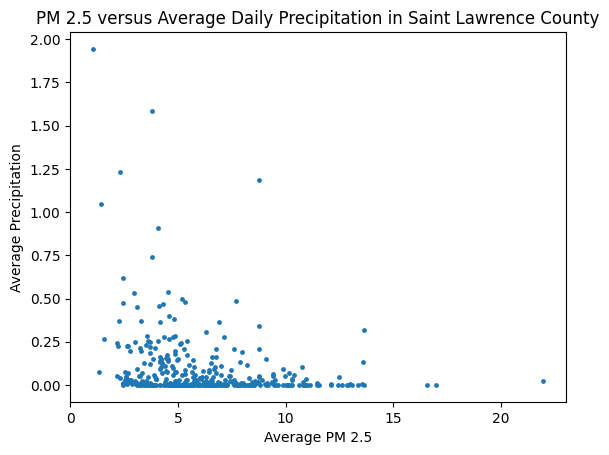

In [4]:
plt.scatter(df_st_law_joined["averagepm2.5"],df_st_law_joined["prcp"], s=6) 
plt.title("PM 2.5 versus Average Daily Precipitation in Saint Lawrence County")
plt.xlabel('Average PM 2.5')
plt.ylabel('Average Precipitation')
plt.savefig("../Images/st_law_Scatter.jpg")
plt.show() 

### St Lawrence Linear Regression

In [27]:
temp_numpy = df_st_law_joined.to_numpy()
temp_numpy = np.hsplit(temp_numpy, 3)
#print(temp_numpy)
model = LinearRegression()
model.fit(temp_numpy[1],temp_numpy[2])
r_sq = model.score(temp_numpy[1],temp_numpy[2])
print("r squared value:",r_sq)
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

r squared value: 0.058766181544834484
intercept: [0.19626341]
slope: [[-0.01714085]]


### Join Percipitation Data with Weather Data for Kings county

In [5]:
df_kings_wea = pd.read_csv("../Data/weather_kings_county.csv")
df_kings_wea = df_kings_wea[['STATION', 'DATE', 'PRCP']]
df_kings_wea["PRCP"]= df_kings_wea["PRCP"].fillna(0)
df_kings_wea = pd.DataFrame(df_kings_wea.groupby(['DATE'])['PRCP'].mean())
df_kings_wea.reset_index(inplace=True)
df_kings_wea['DATE'] = pd.to_datetime(df_kings_wea['DATE'])
df_kings_wea.columns = df_kings_wea.columns.str.lower()


df_kings_pm =  pd.read_csv("../Output/kings_county_2016.csv")
df_kings_pm = df_kings_pm[["date", "averagepm2.5"]]
df_kings_pm['date'] = pd.to_datetime(df_kings_pm['date'])
df_kings_joined = pd.DataFrame.merge(df_kings_pm,df_kings_wea)
df_kings_joined

,date,averagepm2.5,prcp
0,2016-01-01,3.721588,0.00
1,2016-01-02,8.066873,0.00
2,2016-01-03,10.008718,0.00
3,2016-01-04,4.388396,0.00
4,2016-01-05,8.202424,0.00
...,...,...,...
250,2016-12-27,6.292629,0.01
251,2016-12-28,5.578044,0.00
252,2016-12-29,7.736684,0.00
253,2016-12-30,5.769504,0.36


### Graph County Data

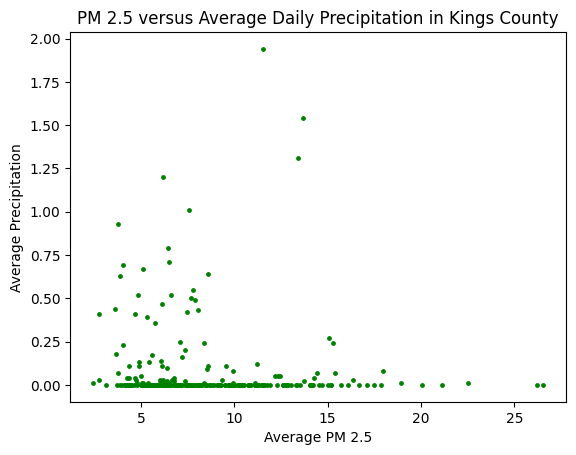

In [6]:
plt.scatter(df_kings_joined["averagepm2.5"],df_kings_joined["prcp"], s=6, color = "green") 
plt.title("PM 2.5 versus Average Daily Precipitation in Kings County")
plt.xlabel('Average PM 2.5')
plt.ylabel('Average Precipitation')
plt.savefig("../Images/kings_scatter.jpg")
plt.show() 

### Kings County Linear Regression

In [ ]:
temp_numpy = df_kings_joined.to_numpy()
temp_numpy = np.hsplit(temp_numpy, 3)
#print(temp_numpy)
model = LinearRegression()
model.fit(temp_numpy[1],temp_numpy[2])
r_sq = model.score(temp_numpy[1],temp_numpy[2])
print("r squared value:",r_sq)
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

### Aggregate Saint Lawrence Data by month

In [7]:
df_st_law_joined_monthly = pd.DataFrame(df_st_law_joined.groupby(df_st_law_joined.date.dt.month)['averagepm2.5',"prcp"].mean())
df_st_law_joined_monthly.reset_index(inplace=True)
monthlist = ["January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
n=0
for row in df_st_law_joined_monthly['date']:
    row= row-1
    row = monthlist[row]
    df_st_law_joined_monthly['date'][n] = row
    n=n+1
df_st_law_joined_monthly= df_st_law_joined_monthly.rename(columns={"date":"month"})
df_st_law_joined_monthly

C:\Users\edsqu\AppData\Local\Temp\ipykernel_11324\1588685826.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_st_law_joined_monthly = pd.DataFrame(df_st_law_joined.groupby(df_st_law_joined.date.dt.month)['averagepm2.5',"prcp"].mean())
C:\Users\edsqu\AppData\Local\Temp\ipykernel_11324\1588685826.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_st_law_joined_monthly['date'][n] = row


,month,averagepm2.5,prcp
0,January,8.622198,0.026935
1,Febuary,6.340767,0.190345
2,March,5.741739,0.078226
3,April,4.715363,0.080770
4,May,6.419410,0.035674
5,June,5.768506,0.103417
6,July,6.917367,0.081498
7,August,6.308683,0.095904
8,September,5.417755,0.077411
9,October,4.374009,0.185156


### Aggregate Kings County Data by Month

In [8]:
df_kings_joined_monthly = pd.DataFrame(df_kings_joined.groupby(df_kings_joined.date.dt.month)['averagepm2.5',"prcp"].mean())
df_kings_joined_monthly.reset_index(inplace=True)
monthlist = ["January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
n=0
for row in df_kings_joined_monthly['date']:
    row= row-1
    row = monthlist[row]
    df_kings_joined_monthly['date'][n] = row
    n=n+1
df_kings_joined_monthly= df_kings_joined_monthly.rename(columns={"date":"month"})
df_kings_joined_monthly

C:\Users\edsqu\AppData\Local\Temp\ipykernel_11324\1461125236.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_kings_joined_monthly = pd.DataFrame(df_kings_joined.groupby(df_kings_joined.date.dt.month)['averagepm2.5',"prcp"].mean())
C:\Users\edsqu\AppData\Local\Temp\ipykernel_11324\1461125236.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kings_joined_monthly['date'][n] = row


,month,averagepm2.5,prcp
0,January,10.107497,0.011905
1,Febuary,7.834536,0.155714
2,March,8.044987,0.066957
3,April,7.515067,0.030000
4,May,8.819452,0.066000
5,June,9.035812,0.065909
6,July,10.724012,0.190000
7,August,8.201176,0.022500
8,September,6.959502,0.063810
9,October,7.749610,0.077391


### Plot aggregated data

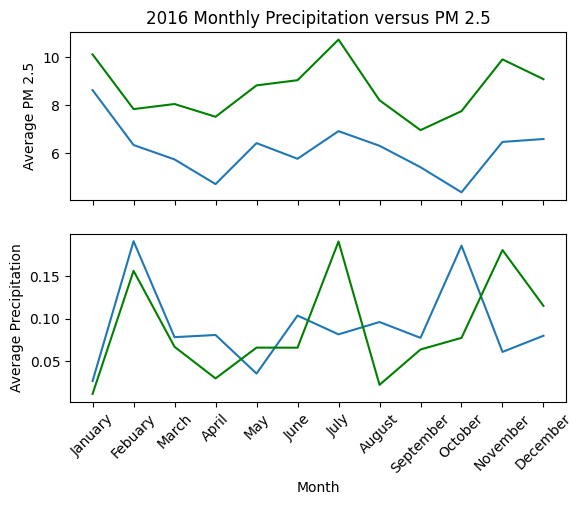

In [9]:
plt.figure(1)
ax1 = plt.subplot(211)
plt.title("2016 Monthly Precipitation versus PM 2.5")
plt.plot(df_st_law_joined_monthly["month"], df_st_law_joined_monthly["averagepm2.5"])
plt.plot(df_kings_joined_monthly["month"], df_kings_joined_monthly["averagepm2.5"], color = "green")
ax2 = plt.subplot(212)
plt.plot(df_st_law_joined_monthly["month"], df_st_law_joined_monthly["prcp"])
plt.plot(df_kings_joined_monthly["month"], df_kings_joined_monthly["prcp"], color = "green")
ax1.xaxis.set_tick_params(labelbottom=False) # labels along the bottom edge are off
plt.xlabel('Month')
ax1.set_ylabel("Average PM 2.5")
ax2.set_ylabel("Average Precipitation")
plt.xticks(rotation=45)
plt.savefig("../Images/comparison_plot.jpg")
plt.show()